In this notebook, we provide some extra analysis for our policy M-UCB, namely,

* Sub-optimal Draws Confidence Interval
* Estimation of Lower Bound of Hazard Rate
* Hyper-parameter Choices
* More arms

Except mentioned, we will use the simulation environment provided in the main paper as our experiment environment. 

In [1]:
# direct to proper path
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import numpy as np
from ipywidgets import IntProgress
from IPython.display import display
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns
import pickle
from prettytable import PrettyTable

from codes.UCB_discrete import M_UCB, UCB1, UCB_V, MV_LCB, Exp3, epsilon_greedy, Median_of_Means_UCB, U_UCB
from codes.Environment import Mixture_AbsGau, setup_env, Exp
from codes.SimulatedGames import simulate
from codes.plots import plot_hist, plot_eva

%matplotlib inline

In [3]:
# setting

num_exper = 50
num_rounds = 10000
num_arms = 3
est_flag = True # estimate the lower bound of hazard rate L

# environment

environments = [
    {Mixture_AbsGau: [[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1]], Exp: [1/3.5]}, # mu1, sigma1, mu2, sigma2, p 
]

rewards_env, medians, means, mvs, samples = setup_env(num_arms, environments)

In [4]:
arm_name_dict = {
    0: 'A',
    1: 'B',
    2: 'C'
}

for key in medians.keys():
    print(key)
    medians[key] = list(np.around(np.array(medians[key]),2))
    means[key] = list(np.around(np.array(means[key]),2))
    mvs[key] = list(np.around(np.array(mvs[key]),2))
    t = PrettyTable(['Eva', 'A', 'B', 'C', 'Best Arm'])
    t.add_row(['Median'] + medians[key]+ [arm_name_dict[np.argmax(medians[key])]])
    t.add_row(['Mean']+ means[key]+ [arm_name_dict[np.argmax(means[key])]])
    #t.add_row(['MV']+ mvs[key]+ [arm_name_dict[np.argmin(mvs[key])]])
    print(t)
    print()

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]
+--------+------+------+------+----------+
|  Eva   |  A   |  B   |  C   | Best Arm |
+--------+------+------+------+----------+
| Median | 2.99 | 2.83 | 2.45 |    A     |
|  Mean  | 3.0  | 3.34 | 3.5  |    C     |
+--------+------+------+------+----------+



In [5]:
# run experiments

est_name_dict = {True: 'est_L_',
                False: 'true_L_'}

def run_exper(results, rewards_env, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [est_flag], fixed_L = None):
    for key in rewards_env.keys():
        for hyperpara in hyperpara_list:
            for est_flag in est_flags:
                name = key + '_' + str(num_exper) + '_' + str(num_rounds)
                policy_name = str(policy).split('.')[-1].split('\'')[0] + '-'
                subname = policy_name + str(hyperpara) + est_name_dict[est_flags[0]] + str(fixed_L)
                print(name + subname)
                p = IntProgress(max = num_exper)
                p.description = 'Running'
                display(p)
                results[name][subname]= simulate(rewards_env[key],summary_stats[key], policy, num_exper, num_rounds, est_flag, hyperpara, fixed_L, p)
                
                # calculate true L
            
                true_L[name][subname] = []
                for i in range(len(rewards_env[key])):
                    my_env = rewards_env[key][i]
                    if hasattr(my_env, 'hazard_rate'):
                        # for Mixture_AbsGau only
                        L = my_env.hazard_rate(0)
                        true_L[name][subname].append(L)
                    elif hasattr(my_env, 'pdf'):
                        # if pdf and cdf is defined
                        L = my_env.pdf(0)/ (1- my_env.cdf(0)) 
                        true_L[name][subname].append(L)
                    else:
                        print('cannot estimate L')

## Sub-optimal Draws Confidence Interval

we show the interval between one standard deviation from the estimated mean. Settings and environments remain the same as the main paper simulation experiment. We can see the confidence interval shrinks as iteration increases. 

In [6]:
results_est_L = defaultdict(dict)
true_L = defaultdict(dict)

# M-UCB

hyperpara_list = [[4,1,1]]
run_exper(results_est_L, rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[4, 1, 1]est_L_None


IntProgress(value=0, description='Running', max=50)

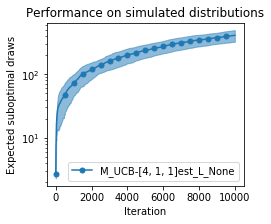

In [7]:
plot_eva(results_est_L, 'sd', paper_flag = False, plot_confi_interval=True)

## Lower bound of hazard rate estimation

Our policy and bound of expected sub-optimal draws depend on the lower bound of hazard rate. One interesting question is how well we can estimate the lower bound of hazard rate ($\hat{L}_i$), and the sensitivity of our policy to the $\hat{L}_i$. 

In [8]:
for name, dicts in results_est_L.items():
    for subname, subdicts in results_est_L[name].items():
        estimated_L = results_est_L[name][subname]['estimated_L']
        true_L_list = true_L[name][subname]

true_L_list

[0.008863696823876015, 0.19069390773026207, 0.2857142857142857]

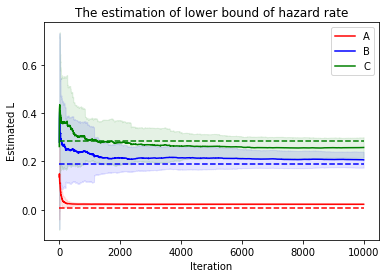

In [17]:
est_L_dict = defaultdict(list)

for i in estimated_L:
    for arm_idx, est_L_list in i.items():
        est_L_dict[arm_idx].append(est_L_list)
colors = ['red', 'blue', 'green']
        
for arm_idx, est_L_lists in est_L_dict.items():
    mean = np.mean(np.asarray(est_L_lists), axis = 0)
    std = np.std(np.asarray(est_L_lists), axis = 0)
    
    plt.plot([0, len(mean)], [true_L_list[arm_idx], true_L_list[arm_idx]], '--', color = colors[arm_idx])
    plt.plot(range(len(mean)), mean, color = colors[arm_idx], label = arm_name_dict[arm_idx])
    plt.fill_between(range(len(mean)), mean + std, mean - std, color = colors[arm_idx], alpha = 0.1)
    plt.ylabel('Estimated L')
    plt.xlabel('Iteration')
    plt.title('The estimation of lower bound of hazard rate')
    plt.legend()
    
plt.savefig('est_L.pdf')

The above plot shows the estimated value of $\hat{L}_i$ for 10,000 rounds experiment under policy M-UCB. Note that the choice of sample arm depends on the policy and the number of samples of each arm is not same. We can see for all arms, the estimated $\hat{L}_i$ converges to the true value (dash line with the same colour) exponentially fast. The estimation remains stable after around 1,000 rounds.

We further show the root mean squared error (RMSE) of lower bound of hazard rate estimation for the first 1,000 iterations. We observe that the error drops exponentially fast for the first 200 iterations and then drops slowly. 

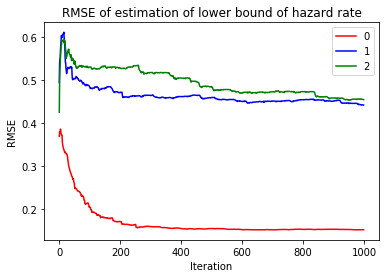

In [18]:
analysis_rounds = 1000

for arm_idx, est_L_lists in est_L_dict.items():
    mean = np.mean(np.asarray(est_L_lists), axis = 0)
    std = np.std(np.asarray(est_L_lists), axis = 0)
    
    plt.plot(range(len(mean[:analysis_rounds])), (np.sqrt(mean - true_L_list[arm_idx] ** 2))[:analysis_rounds], color = colors[arm_idx], label = arm_idx)

    plt.ylabel('RMSE')
    plt.xlabel('Iteration')
    plt.title('RMSE of estimation of lower bound of hazard rate')
    plt.legend()
    
plt.savefig('RMSE_est_L.pdf')

To analyse the sensitiveness our algorithm to the estimation of the lower bound of hazard rate, we set three groups with fixed value of $\hat{L}_i$ as policy input:  
1) $L\_at\_10$: take the estimation at 10th iteration, where the $\hat{L}_i$ is poorly estimated;  
2) $L\_at\_200$: take the estimation at 200th iteration, where the error of estimation has dropped dramatically;  
3) True L: the true value of $L_i$.  

In [12]:
fixed_L_10 = []
fixed_L_200 = []

for arm_idx, est_L_lists in est_L_dict.items():
    mean = np.mean(np.asarray(est_L_lists), axis = 0)
    fixed_L_10.append(mean[10].round(3))
    fixed_L_200.append(mean[200].round(3))

In [13]:
# Group I) L_at_10

hyperpara_list = [[4,1,1]]
run_exper(results_est_L, rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians, fixed_L = fixed_L_10)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[4, 1, 1]est_L_[0.127, 0.4, 0.431]


IntProgress(value=0, description='Running', max=50)

In [14]:
# Group II) L_at_200
run_exper(results_est_L, rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians, fixed_L = fixed_L_200)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[4, 1, 1]est_L_[0.029, 0.258, 0.36]


IntProgress(value=0, description='Running', max=50)

In [15]:
# True L
run_exper(results_est_L, rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians, est_flags = [False])

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[4, 1, 1]true_L_None


IntProgress(value=0, description='Running', max=50)

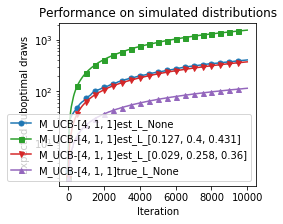

In [16]:
plot_eva(results_est_L, 'sd', paper_flag = False)

As we expected, the "True L" group gives the best performance. 
The estimated L (same as main paper results) and the fixed estimated $\hat{L}_i$ at 200th iteration give similar performance. 
"L\_at\_200" has a slightly better performance at the beginning, which is because it gets rid of the error caused by very poor estimations at the first 200 iterations. 
Note the gap between the "Estimated L" and "True L" group is about 500 draws, which is caused by the poor estimation at the beginning state. 
The increase rates of sub-optimal draws are similar to both groups in the later iterations. 
The "L\_at\_10" group has the worst performance, where the gap between it and the "Estimated L" group is also about 500 draws. 
The increase rate of "L\_at\_10" group remains a little bit higher than other groups. 

From the above comparison, being able to estimate the lower bound of hazard rate correctly allows the algorithm to converge faster and therefore to achieve a smaller number of sub-optimal draws. 
However, the algorithm is not highly sensitive to the estimation of lower bound of hazard rate. Even if we use a very poor estimation of $\hat{L}_i$ (L\_at\_10), we are still able to achieve a reasonable convergence. 

## Hyperparameter choices

Our policy has two hyper-parameters: $\alpha$ and $\beta$. Since our proof is constrained as $\beta = 1$ and $\alpha > 1$, we use $\beta = 1$ for our practical tests. For the choice of $\alpha$, intuitively, we would like to use a higher value of $\alpha$ for the environments needed more exploration (e.g. small gaps between medians, high variance). We set $\alpha = 1.5, 2, 4, 10$. We observe that the performance is not sensitive to the value of $\alpha$, where the sub-optimal draws decreases when $\alpha$ becomes smaller. 

In [21]:
results_hyperpara = defaultdict(dict)

hyperpara_list = [[1.5,1,1], [2,1,1], [4,1,1], [10,1,1]]
run_exper(results_hyperpara, rewards_env, hyperpara_list, num_exper, num_rounds, M_UCB, medians, fixed_L = None)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[1.5, 1, 1]est_L_None


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[2, 1, 1]est_L_None


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[4, 1, 1]est_L_None


IntProgress(value=0, description='Running', max=50)

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_50_10000M_UCB-[10, 1, 1]est_L_None


IntProgress(value=0, description='Running', max=50)

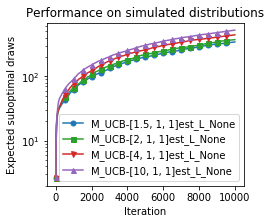

In [22]:
plot_eva(results_hyperpara, 'sd', paper_flag = False)

## More arms

We analysed the dependence of our algorithm on the number of arms $K$. We show the expected sub-optimal draws of our algorithm and U-UCB after 10,000 iterations for $K$ from 3 to 10. The simulation environment of the first three arms remains the same as the one we use in the main paper, the rest arms are an absolute Gaussian with mean 1.2 and standard deviation 4 (the same as Arm B). 

In [19]:
# setting

num_exper = 100
num_rounds = 10000

est_flag = True # estimate the lower bound of hazard rate L

# environment

# more arm iwth Mixture_AbsGau
more_arms = [[1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1],[1.2, 4, 0, 1, 1],[1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]


def run_exper(results, more_arms, hyperpara_list, num_exper, num_rounds, policy, summary_stats, est_flags = [est_flag], fixed_L = None):
    for i in range(3, 3 + len(more_arms)):
        environments = {Mixture_AbsGau: [[3, 1, 0,1, 1], [1.2, 4, 0, 1, 1]] + more_arms[: i -3], Exp: [1/3.5]}, # mu1, sigma1, mu2, sigma2, p
        rewards_env, medians, means, mvs, samples = setup_env(i, environments)

        for key in rewards_env.keys():
            if summary_stats == 'medians':
                metric = list(np.around(np.array(medians[key]),2))
            elif summary_stats == 'means':
                metric = list(np.around(np.array(means[key]),2))
            for hyperpara in hyperpara_list:
                for est_flag in est_flags:
                    policy_name = str(policy).split('.')[-1].split('\'')[0] 
                    name = key + '_' + str(num_exper) + '_' + str(num_rounds) + '_' + str(i)+ 'arms-' 
                    subname = policy_name  +  str(hyperpara) 
                    print(name + subname)
                    p = IntProgress(max = num_exper)
                    p.description = 'Running'
                    display(p)
                    results[name][subname]= simulate(rewards_env[key],metric, policy, num_exper, num_rounds, est_flag, hyperpara, fixed_L, p)

In [20]:
results_more_arms = defaultdict(dict)

# M-UCB

hyperpara_list = [[4,1,1]]


run_exper(results_more_arms, more_arms, hyperpara_list, num_exper, num_rounds, M_UCB, 'medians')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_3arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_4arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_5arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_6arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_7arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_8arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_9arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_10arms-M_UCB[4, 1, 1]


IntProgress(value=0, description='Running')

In [21]:
# U-UCB

hyperpara_list = [[4]]
run_exper(results_more_arms, more_arms, hyperpara_list, num_exper, num_rounds, U_UCB, 'medians')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_3arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_4arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_5arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_6arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_7arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_8arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_9arms-U_UCB[4]


IntProgress(value=0, description='Running')

Mixture_AbsGau_[[3, 1, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1], [1.2, 4, 0, 1, 1]]Exp_[0.2857142857142857]_100_10000_10arms-U_UCB[4]


IntProgress(value=0, description='Running')

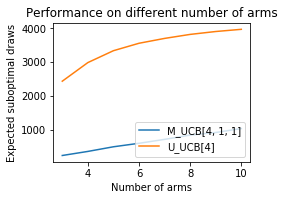

In [22]:
from codes.plots import plot_eva_num_arms

plot_eva_num_arms(results_more_arms, 'sd', mean_at = 4500, paper_flag = False)

The empirical results show that the expected sub-optimal draws grow linearly with the number of arms for our policy, which is the same as what our bound predicts. Moreover, Our algorithm significantly outperforms U-UCB, although the sub-optimal arms of U-UCB grow in logarithmic rate when the number of arms is smaller than 6. 

## Save results

In [23]:
import pickle

with open('results_more_arms.pickle', 'wb') as handle:
    pickle.dump(results_more_arms, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [23]:
with open('results_hyperpara.pickle', 'wb') as handle:
    pickle.dump(results_hyperpara, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [20]:
with open('results_est_L.pickle', 'wb') as handle:
    pickle.dump(results_est_L, handle, protocol=pickle.HIGHEST_PROTOCOL)